# PID with FF simulation

## Import libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_LAB import *
from package_DBR import *

## Simulation params

In [2]:
TSim = 2200
Ts = 1.0

# Initial working points 
MV0 = 50
DV0 = 50
PV0 = 75

# Paths
SPPath = {0: 75, 800: 65}
DVPath = {0: DV0, 1500: DV0+5}
manPath = {0: True, 750 : False, TSim: False}
manMVPath = {0: MV0, TSim: MV0}

# Parameters for input-output dynamics
Kp = 0.57
T1p = 172.4
T2p = 2.8
Thetap = 2.0

# G & H, voir A

# Parameters for disturbance dynamics
Kd = 0.29
T1d = 127.9
T2d = 21.8
Thetad = 12.4

# Parameters for the PID controller 
alpha = 0.5
gamma = 0.4
Tc = gamma * T1p
Kc, Ti, Td = IMC_Tuning(Kp, Thetap, Tc, T1p, T2p)
discretisation = ["TRAP", "TRAP"]


## Determine PID gains with IMC tuning

In [3]:
Kc = 0
Ti = 0
Td = 0

Kc,Ti,Td = IMC_Tuning(Kp, Tc, Thetap, T1p, T2p)
print("Kc = {}, ti = {}, td = {}".format(Kc, Ti, Td))

Kc = 4.262346960976285, ti = 172.4, td = 0


## Simulate

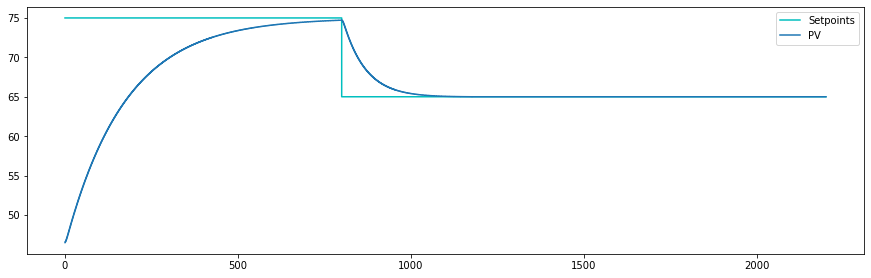

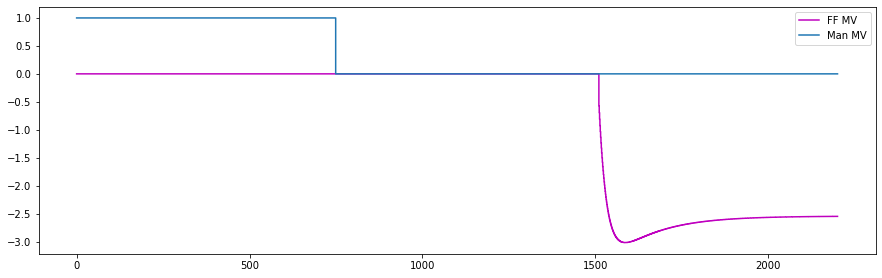

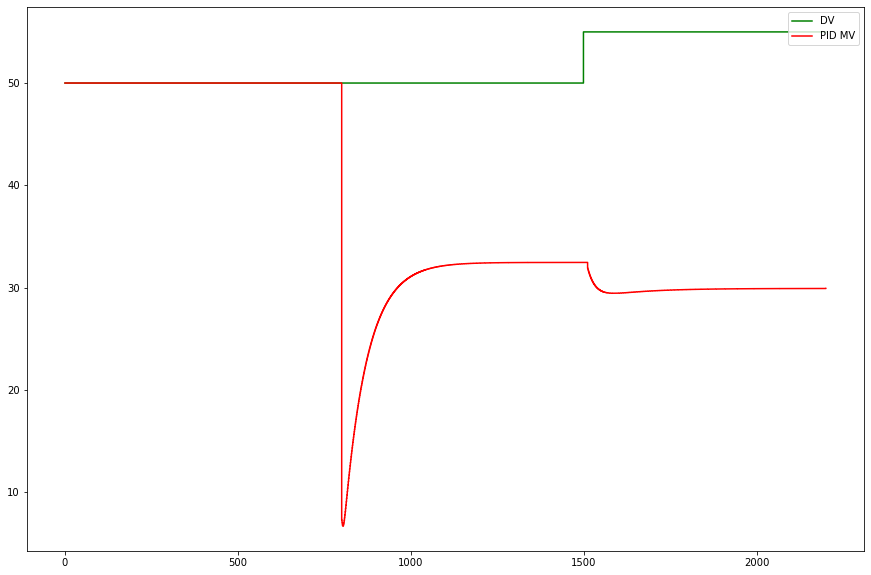

In [35]:
PV = []
MV = {"MV" : [], "MVp" : [], "MVi": [],  "MVd": [], "E" : []}

N = int(TSim/Ts)+1

t = []
SP = []
DV = []

Man = []
MVMan = []
MVFF = []

MVFFDelay = []
MVFFLL1 = []

MVDelay = []
PV1p = []
PV2p = []
ActivateFF = True

DVDelay = []
PV1d = []
PV2d = []

#def PID_RT(PV, SP, MV, Ts, Kc, Ti, Td, alpha, 
#          approximationType, PVinit=0, man=False, manMV=[0], FF_MV=[0], FF_MV_init=0, MVmin=0, MVmax=100):

#Kc, Ti, Td = 2.5, 170, 2.5

for i in range(0, N):
    
    t.append(i*Ts)

    # Input signal SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    # FeedForward
    Delay_RT(DV-DV0*np.ones_like(DV), np.max([Thetad-Thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp, T1d, T1p, Ts, MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1, 1, T2d, T2p, Ts, MVFF)
    else:
        #LeadLag_RT(MVFFLL1, 0, T2d, T2p, Ts, MVFF)
        MVFF.append(0)
    
    # PID controller mode
    SelectPath_RT(manPath,t,Man)
    SelectPath_RT(manMVPath, t, MVMan)
    
    # PID controller
    PID_RT(PV, SP[i], MV, Ts, Kc, Ti, Td, alpha, discretisation, PVinit=PV0, man=Man[i], manMV=MVMan, FF_MV=MVFF)
    # Process Dynamics
    Delay_RT(MV["MV"], Thetap, Ts, MVDelay, MV0)
    FO_RT(MVDelay, Kp, T1p, Ts, PV1p, 0)
    FO_RT(PV1p, 1, T2p, Ts, PV2p, 0)

    # Disturbance dynamics
    Delay_RT(DV - DV0*np.ones_like(DV), Thetad, Ts, DVDelay, 0)
    FO_RT(DVDelay, Kd, T1d, Ts, PV1d, 0)
    FO_RT(PV1d, 1, T2d, Ts, PV2d, 0)

    PV.append(PV2p[-1] + PV2d[-1] + PV0 - Kp * MV0)
    #print("PV2p[-1]= {}, PV2d[-1] = {}, PV0 = {}, Kp = {}, MV0 = {}".format(PV2p[-1],PV2d[-1] ,PV0 , Kp , MV0))
    
  

f = plt.figure(0)
f.set_figwidth(15)
f.set_figheight(10)
plt.subplot(2,1,1)
plt.step(t, np.array(SP),'c-', label='Setpoints',where='post')
plt.step(t, np.array(PV), label='PV')
plt.legend(loc='best')
s = plt.figure(1)
s.set_figwidth(15)
s.set_figheight(10)
plt.subplot(2,1,2)
plt.step(t, np.array(MVFF),'m', label='FF MV')
plt.step(t, np.array(Man), label='Man MV')
plt.legend(loc='best')
s = plt.figure(2)
s.set_figwidth(15)
s.set_figheight(10)
plt.step(t, np.array(DV),'g', label='DV')
plt.step(t, np.array(MV["MV"]),'r', label='PID MV', where='post')

plt.legend(loc='upper right')

plt.show()